In [42]:
# to avoid to restart kernel when external modules are modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import sys

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../.")

from image_to_melody.img_utils import (
    get_k_representatives, get_representative_pixels
)

## RGB Approach

In [70]:
base_path = "../sample_images"
sample_img_filename = "001_hubble_deep_space.jpg"

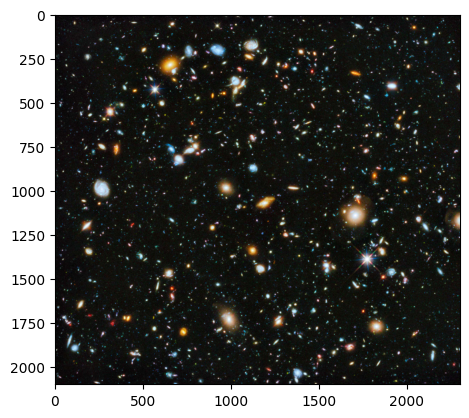

In [71]:
img = cv2.imread(filename=f"{base_path}/{sample_img_filename}")
color_image = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)

plt.imshow(color_image)
plt.show()

In [72]:
height, width, channels = color_image.shape
number_slices = 25
k = 5
# split the width in number_slices slices, and compute the K representative pixels
slice_width = width // number_slices

print("slice size", (height, slice_width))

slice size (2100, 92)


In [73]:
all_representative_pixels = get_representative_pixels(color_image, number_slices, k)

In [74]:
df_repixels = pd.DataFrame(
    all_representative_pixels, columns=["red", "green", "blue"]
)
df_repixels.shape

(125, 3)

In [75]:
print("RED MAX", df_repixels["red"].max())
print("GREEN MAX", df_repixels["green"].max())
print("BLUE MAX", df_repixels["blue"].max())

RED MAX 200.26205704407298
GREEN MAX 211.56079255478886
BLUE MAX 223.04563194235828


### RGB pixels to frequencies

In [76]:
# generate frequencies
frequencies = np.linspace(start=20, stop=2000, num=255)
frequencies.shape, type(frequencies)

((255,), numpy.ndarray)

In [77]:
frequencies[:20]

array([ 20.        ,  27.79527559,  35.59055118,  43.38582677,
        51.18110236,  58.97637795,  66.77165354,  74.56692913,
        82.36220472,  90.15748031,  97.95275591, 105.7480315 ,
       113.54330709, 121.33858268, 129.13385827, 136.92913386,
       144.72440945, 152.51968504, 160.31496063, 168.11023622])

In [78]:
def rgb_to_freq(r: int, g: int, b: int, freqs: np.ndarray):
    idx = int(r + g + b) // 3

    return freqs[idx]

In [79]:
# add new column with the mapped frequency of the pixel values

df_repixels["notes"] = df_repixels.apply(
    lambda row : rgb_to_freq(row["red"], row["green"], row["blue"], frequencies), axis=1
)     
df_repixels.head(10)

red       green        blue        notes
0   11.412487    9.237361    9.763022    97.952756
1   21.025189   19.750166   20.422919   175.905512
2   49.209412   56.794454   59.413782   448.740157
3  101.369270  116.050085  125.673175   908.661417
4  170.246096  198.688320  217.095565  1540.078740
5   13.935739   11.994037   11.206297   113.543307
6   25.195081   24.287101   22.988650   207.086614
7   66.096838   64.747609   54.106137   495.511811
8  119.799823  126.112064  123.717918   978.818898
9  185.122357  208.224957  217.138995  1602.440945

### RGB pixels to octaves

In [80]:
def rgb_to_octave(r: int, g: int, b: int, octave_values: list) -> float:
    # those are the threshold of the rgb values.
    # generate equidistant thresholds
    thresholds = np.linspace(start=0, stop=255, num=len(octave_values))

    assert len(octave_values) == len(thresholds)

    octave = octave_values[0]
    avg_intensity = int(r + g + b) // 3

    for idx, threshold in enumerate(thresholds):
        if avg_intensity < threshold:
            octave = octave_values[idx]
            break

    return octave

In [81]:
# add column with the mapped octave value using the saturation value
octave_values = [
    0.5, 1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2
]

df_repixels["octave"] = df_repixels.apply(
    lambda row : rgb_to_octave(row["red"], row["green"], row["blue"], octave_values), axis=1
)     
df_repixels.head(10)

red       green        blue        notes    octave
0   11.412487    9.237361    9.763022    97.952756  1.000000
1   21.025189   19.750166   20.422919   175.905512  1.066667
2   49.209412   56.794454   59.413782   448.740157  1.125000
3  101.369270  116.050085  125.673175   908.661417  1.333333
4  170.246096  198.688320  217.095565  1540.078740  1.666667
5   13.935739   11.994037   11.206297   113.543307  1.000000
6   25.195081   24.287101   22.988650   207.086614  1.066667
7   66.096838   64.747609   54.106137   495.511811  1.200000
8  119.799823  126.112064  123.717918   978.818898  1.406250
9  185.122357  208.224957  217.138995  1602.440945  1.800000

### Check stats

In [82]:
df_repixels.describe()

red       green        blue        notes      octave
count  125.000000  125.000000  125.000000   125.000000  125.000000
mean    89.038866   91.887446   86.446407   711.035591    1.289450
std     65.697524   69.610247   74.371884   533.681478    0.275223
min     11.412487    9.237361    9.687087    97.952756    1.000000
25%     25.195081   26.119843   22.762173   207.086614    1.066667
50%     72.810172   69.612889   55.951581   534.488189    1.200000
75%    159.383033  132.426862  132.737084  1010.000000    1.406250
max    200.262057  211.560793  223.045632  1633.622047    1.800000

In [83]:
df_repixels["notes"].unique().shape, df_repixels["octave"].unique()

((71,),
 array([1.        , 1.06666667, 1.125     , 1.33333333, 1.66666667,
        1.2       , 1.40625   , 1.8       , 1.25      , 1.5       ]))

### Create playable audio

In [84]:
frequencies = df_repixels["notes"].to_numpy()
octaves = df_repixels["octave"].to_numpy()

In [85]:
sample_rate = 44100 # 44.1 KHz - standard used in most CDs and digital audio formats
T = 0.23

# t represents an array of int(T*sample_rate) time values starting from 0 
# and ending at T, with a # fixed duration between each sample
t = np.linspace(0, T, int(T*sample_rate), endpoint=False) # time variable

In [86]:
import IPython.display as ipd

song = np.array([])
print("Num pixes of the sample", int(len(frequencies)))


for octave, freq in zip(octaves, frequencies):
    val = freq * octave
    note = 0.5 * np.sin(2 * np.pi * val * t)
    song  = np.concatenate([song, note]) # Add notes into song array to make song

Num pixes of the sample 125


In [87]:
ipd.Audio(data=song, rate=sample_rate, autoplay=True) # load a NumPy array as audio

In [88]:
from scipy.io import wavfile

audio_filename = sample_img_filename.split(".")[0]
audio_path = f"../outputs/exp_1/{audio_filename}_rgb.wav"

wavfile.write( 
    audio_path,
    rate=sample_rate,
    data=song.astype(np.float32)
)

### Effects with Pedalboard

In [89]:
from pedalboard import (
    Pedalboard,
    Chorus,
    LadderFilter,
    Gain,
    Reverb,
    Delay,
    Phaser,
    Compressor,
    Limiter,
    HighpassFilter,
    PitchShift
)
from pedalboard.io import AudioFile

In [90]:
# Make a Pedalboard object, containing multiple audio plugins:
board = Pedalboard([
    Chorus(depth=0.15),
    Delay(delay_seconds=0.1),
    Reverb(room_size=0.5)
])

audio_examples = [
    audio_path
]

for audio_example_path in audio_examples:
    with AudioFile(audio_example_path) as f:
        new_path = audio_example_path.replace(".wav", "_effected.wav")
        with AudioFile(new_path, "w", f.samplerate, f.num_channels) as o:
            # Read one second of audio at a time, until the file is empty:
            while f.tell() < f.frames:
                chunk = f.read(int(f.samplerate))

                # Run the audio through our pedalboard:
                effected = board(chunk, f.samplerate, reset=False)

                # Write the output to our output file:
                o.write(effected)

ipd.Audio(new_path) # load a NumPy array as audio